In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm
import seaborn as sns; sns.set()
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress
from tools.cartesian_grid_2d import haversine

In [2]:
grid_path = os.path.join(int_dir,'grd2_dV.nc')
u_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_u_avg.nc')
v_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_v_avg.nc')
ubar_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_ubar_avg.nc')
vbar_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_vbar_avg.nc')
zeta_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m_avg.nc')
sector_masks_path = os.path.join(int_dir,'mask_sector_2.npy') 
shelves_masks_path = os.path.join(int_dir,'shelves2.npy') 

grd = xr.open_dataset(grid_path)
u = xr.open_dataset(u_path).u.squeeze()
v = xr.open_dataset(v_path).v.squeeze()
ubar = xr.open_dataset(ubar_path).ubar.squeeze()
vbar = xr.open_dataset(vbar_path).vbar.squeeze()
zeta = xr.open_dataset(zeta_path).zeta.squeeze()
temp = xr.open_dataset(temp_path).temp.squeeze()
salt = xr.open_dataset(salt_path).salt.squeeze()
m = xr.open_dataset(m_path).m
sector = np.load(sector_masks_path,allow_pickle=True).item()
shelves = np.load(shelves_masks_path,allow_pickle=True).item()

In [26]:
avg[(avg['sector'] == 'Amundsen Sea') | (avg['sector'] == 'Bellingshausen Sea')].mean()

ismr            2.646780
lat           -72.966208
lon           -95.377591
area            3.614442
temp_ocean     -1.040626
salt_ocean     34.162603
depth        -224.766231
RMS_tides       0.010124
ubar_mean       0.008401
temp_mean      -1.236421
salt_mean      34.099691
dtype: float64

In [3]:
avg = pd.DataFrame.from_dict(shelves).T[['ismr','lat','lon','A','Tm_front','Salt_front','depth','tv4']]
avg.rename(columns={'A':'area','Tm_front':'temp_ocean','Salt_front':'salt_ocean','tv4':'RMS_tides'},inplace=True)

for i in ['lat','lon']:
    for k,v in avg[i].items():
        avg[i][k]=v.mean()

s2a = 3600*24*365.25       
for krow,vrow in avg.iterrows():
    avg['ismr'][krow] = vrow['ismr']*s2a
    avg['temp_ocean'][krow] = vrow['temp_ocean'].values
avg = avg.astype('float')

In [7]:
avg['sector'] = pd.DataFrame.from_dict(shelves).T['sector']

avg.replace({'George V Coast/Wilkes subglacial basin':'George V Coast',
             'Sabrina Coast/Aurora subglacial basin':'Sabrina Coast'},inplace=True)

In [8]:
def make_uv_mag(u, v):

    # Interpolate u to the rho-grid
    w_bdry_u = u[:,0]
    middle_u = 0.5*(u[:,0:-1] + u[:,1:])
    e_bdry_u = u[:,-1]
    u_rho = np.ma.concatenate((w_bdry_u[:,np.newaxis], middle_u, e_bdry_u[:,np.newaxis]), axis=1)
    # Interplate v to the rho-grid
    s_bdry_v = v[0,:]
    middle_v = 0.5*(v[0:-1,:] + v[1:,:])
    n_bdry_v = v[-1,:]
    v_rho = np.ma.concatenate((s_bdry_v[np.newaxis,:], middle_v, n_bdry_v[np.newaxis,:]), axis=0)

    return xr.DataArray(xr.ufuncs.sqrt(xr.ufuncs.square(u_rho)+xr.ufuncs.square(v_rho)),dims=('eta_rho','xi_rho'))

ubar_mag = make_uv_mag(ubar.values,vbar.values)

In [9]:
avg['ubar_mean'] = 0.0

A = (grd.pn*grd.pm)**(-1)
for k,v in log_progress(shelves.items(),every=2):
    mask = v['mask']
    weights = A.where(mask)/A.where(mask).sum()
    avg['ubar_mean'][k]=(ubar_mag*weights).sum().values

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [18]:
from dask.distributed import Client
C = Client()
C

Client Scheduler: tcp://127.0.0.1:55638 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [19]:
avg['temp_mean'] = 0.0
avg['salt_mean'] = 0.0

chunks = {'eta_rho':180,'xi_rho':180}

for k,v in log_progress(shelves.items(),every=2):
    mask = v['mask']
    weights = grd.dV.chunk(chunks).where(mask)/grd.dV.chunk(chunks).where(mask).sum()
    avg['temp_mean'][k]=(temp.chunk(chunks)*weights).sum().values
    avg['salt_mean'][k]=(salt.chunk(chunks)*weights).sum().values

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 51% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 52% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [20]:
out_path = os.path.join(int_dirir,'avg_features.feather')
avg.to_feather(out_path)

ImportError: the feather-format library is not installed
you can install via conda
conda install feather-format -c conda-forge
or via pip
pip install -U feather-format


In [111]:
def make_mask_front(grd,nb_cells,name):
    
    mask_rho = grd.mask_rho.values
    mask_land = np.zeros_like(mask_rho)
    mask_land[mask_rho == 0] = 1
    mask_zice = np.zeros_like(mask_land)
    mask_zice[grd.zice.values*mask_rho != 0] = 1

    mask_front = np.zeros_like(grd.mask_rho.values)

    for j in log_progress(grd.eta_rho.values):
        for i in grd. xi_rho.values:
            if mask_zice[j,i] == 1:
                j_min = max(j-nb_cells,0)
                j_max = min(j+nb_cells, np.size(mask_rho,0))
                i_min = max(i-nb_cells,0)
                i_max = min(i+nb_cells+1, np.size(mask_rho,1))

                if np.any(mask_zice[j_min:j_max,i_min:i_max] + mask_land[j_min:j_max,i_min:i_max]== 0):
                        mask_front[j,i] = 1
                        
    grd['mask_'+name] = (('eta_rho','xi_rho'),mask_front)
    
    return grd

grd = make_mask_front(grd,7,'frontal_zone')
grd = make_mask_front(grd,1,'front')

<xarray.Dataset>
Dimensions:    (eta_psi: 2649, eta_rho: 2650, eta_u: 2650, eta_v: 2649, s_rho: 31, xi_psi: 3149, xi_rho: 3150, xi_u: 3149, xi_v: 3150)
Dimensions without coordinates: eta_psi, eta_rho, eta_u, eta_v, s_rho, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    spherical  int64 ...
    xl         int64 ...
    el         int64 ...
    angle      (eta_rho, xi_rho) float64 ...
    pm         (eta_rho, xi_rho) float64 ...
    pn         (eta_rho, xi_rho) float64 ...
    dndx       (eta_rho, xi_rho) float64 ...
    dmde       (eta_rho, xi_rho) float64 ...
    f          (eta_rho, xi_rho) float64 ...
    h          (eta_rho, xi_rho) float64 ...
    hraw       (eta_rho, xi_rho) float64 ...
    zice       (eta_rho, xi_rho) float64 ...
    lon_rho    (eta_rho, xi_rho) float64 ...
    lat_rho    (eta_rho, xi_rho) float64 ...
    lon_psi    (eta_psi, xi_psi) float64 ...
    lat_psi    (eta_psi, xi_psi) float64 ...
    lon_u      (eta_u, xi_u) float64 ...
    lat_u      (eta_u, xi_u) floa

In [112]:
for k,v in shelves.items():
    #shelves[k]['mask_open_ocean'] = shelves[k].pop('front_mask')
    shelves[k]['mask_front'] = (grd.mask_front == 1) & (shelves[k]['mask'] == 1)
    shelves[k]['mask_frontal_zone'] = (grd.mask_frontal_zone == 1) & (shelves[k]['mask'] == 1)

In [113]:
grad = np.gradient(-grd.zice,10000)
magGradz = np.sqrt(grad[0]**2 + grad[1]**2)
gradz = xr.DataArray(magGradz,dims=('eta_rho','xi_rho'),name='gradz').where((grd.mask_rho==1)&(grd.zice>0))
gradz.name = 'gradZice'
grd['grad_zice'] = gradz
grd['wct'] = grd.h-grd.zice

for k,v in log_progress(shelves.items(),every=2):
    for quant in ['h','zice','grad_zice','wct']:
        for fr_key in ['','_frontal_zone']: 
            avg[k][quant+fr_key+'_mean'] = grd[quant].where(v['mask'+fr_key]).mean().values
            avg[k][quant+fr_key+'_min'] = grd[quant].where(v['mask'+fr_key]).min().values
            avg[k][quant+fr_key+'_max'] = grd[quant].where(v['mask'+fr_key]).max().values
            avg[k][quant+fr_key+'_std'] = grd[quant].where(v['mask'+fr_key]).std().values

In [68]:
#for k,v in log_progress(shelves.items(),every=2):
#    avg[k]['front_face_size'] = grd.dV.where(shelves[k]['mask_front']).sum()

KeyboardInterrupt: 

In [114]:
mask_shelf_break = ((grd.h > 2000) & (grd.h < 2100) & (grd.mask_rho ==1) & (grd.zice == 0.0))

In [115]:
lon_s = grd.lon_rho.values[mask_shelf_break]
lat_s = grd.lat_rho.values[mask_shelf_break]

for k,item in avg.iteritems():
    
    lon_i = np.repeat(item.lon,lat_s.shape[0])
    lat_i = np.repeat(item.lat,lat_s.shape[0])

    avg[k]['dist_shelf_break'] = min(haversine(lon_i,lat_i,lon_s,lat_s))

In [120]:
std = grd.lon_rho.where(shelves['Amery']['mask']).std()

haversine(avg['Amery'].lon+std,avg['Amery'].lat,avg['Amery'].lon-std,avg['Amery'].lat)

<xarray.DataArray 'lon_rho' ()>
array(121403.921023)

<IPython.core.display.Javascript object>


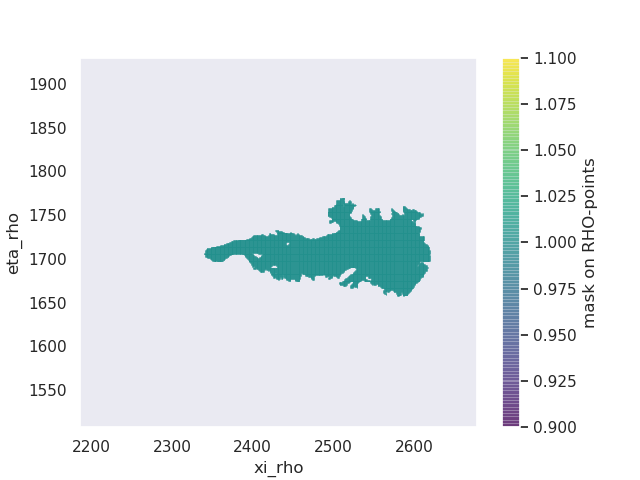

In [121]:
plt.close()
grd.mask_rho.where(shelves['Amery']['mask']).plot(alpha=0.5,size=7)
#grd.mask_rho.where(avg['Amery'].lon+std | )
plt.show()

In [132]:
avg.T.tv4

Abbot                           0.022732858852395024
Abbot 1                                          0.0
Abbot 2                         0.005128922762232208
Abbot 3                         0.008499587678753235
Abbot 4                         0.005462076837003621
Abbot 5                          0.01105004773904571
Abbot 6                         0.001642216444997389
Ainsworth                                        0.0
Alison                                           0.0
Amery                            0.04742606612729294
Andreyev                                         0.0
Astrolabe                      0.0045929041402472115
Atka                             0.03021058064557192
Aviator                         0.011987865855796195
Bach                            0.058818156967763505
Barber                                           0.0
Baudouin                        0.034997903650250364
Borchgrevink                     0.03240681496386561
Brahms                           0.00288744109

In [123]:
for k,v in log_progress(shelves.items(),every=2):
    mask = v['mask']
    weights = grd.dV.where(mask)/grd.dV.where(mask).sum()
    shelves[k]['u']=(u_mag*weights).sum()

for k,v in log_progress(shelves.items(),every=2):
    mask = v['front_mask']
    weights = grd.dV.where(mask)/grd.dV.where(mask).sum()
    shelves[k]['u_front']=(u_mag*weights).sum()
    
avg['u'] = pd.DataFrame.from_dict(shelves).T['u'].astype(float)    
avg['u_front'] = pd.DataFrame.from_dict(shelves).T['u_front'].astype(float)
avg['u+u_tide'] = avg['tv4']+avg['u'][avg['tv4']]
avg['u+u_tide'] = avg['tv4']+avg['u'][avg['tv4'].index]

NameError: name 'u_mag' is not defined

In [ ]:
haversine(grd.lon_rho.where(mask))

In [27]:
for k,v in log_progress(shelves.items(),every=2):
    for quant in ['h','zice','grad_zice']:

{'lat': array([-72.34363875, -72.34527678, -72.35989587, ..., -73.32096137,
        -73.33704163, -73.3389019 ]),
 'lon': array([-95.2534635 , -95.19442891, -95.31798046, ..., -95.88244559,
        -95.95142228, -95.8888892 ]),
 'eta': array([1125, 1125, 1125, ..., 1364, 1364, 1364]),
 'xi': array([553, 554, 555, ..., 565, 566, 567]),
 'mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'xi_mid': 566.0,
 'eta_mid': 1248.0,
 'A': 29.022911323399068,
 'ismr': array(8.5817609e-08),
 'ismr_l': 2.712395388983669,
 'ismr_g': -1.0238414170024881e-05,
 'bmb': 72.10872334909251,
 'bml': 72.10899553719779,
 'bmg': -0.00027218810527875997,
 'ismr_max': 17.365849537691247,
 'ismr_min': -0.0

In [26]:
avg['Abbot']

ismr                             2.7082
lat                            -72.7956
lon                            -96.4683
A                               29.0229
Tm_front            -0.7664164326168367
Salt_front           34.170611812118096
sector                     Amundsen Sea
depth               -235.77483978431812
tv4                0.022732858852395024
h_mean               358.07746546045803
h_min                 54.61296687619772
h_max                             726.0
h_std                109.63458132745467
zice_mean            235.69948997472358
zice_min                            3.0
zice_max              700.4854780249404
zice_std              81.41554745273713
grad_zice_mean    0.0017828441860147975
grad_zice_min                       0.0
grad_zice_max      0.016932216823130623
grad_zice_std     0.0015633806175796474
Name: Abbot, dtype: object

In [23]:
xi,eta = np.meshgrid(grd2.xi_rho,grd2.eta_rho)

In [103]:
x = [None  for x in range(grd2.xi_rho.size)]
x = np.broadcast_to(x,grd2.mask_rho.shape).astype('U15')
#mask_map = np.zeros_like(name_map)
for key,values in log_progress(shelves2.items(),every=2):
    x[values['mask']]=key
    #mask_map[values['mask']]=1
        
#mask_map = xr.DataArray(name_map,dims=('eta_rho','xi_rho')).where(mask_map)

In [113]:
grad = np.gradient(grd2.zice,10000)
magGradz = np.sqrt(grad[0]**2 + grad[1]**2)
gradz = xr.DataArray(magGradz,dims=('eta_rho','xi_rho'),name='gradz').where((grd2.mask_rho==1)&(grd2.zice<0))
gradz.name = 'gradZice'

In [115]:
shelves2['Abbot']['front_mask']

dict_keys(['lat', 'lon', 'eta', 'xi', 'mask', 'xi_mid', 'eta_mid', 'A', 'ismr', 'ismr_l', 'ismr_g', 'bmb', 'bml', 'bmg', 'ismr_max', 'ismr_min', 'sector', 'sector_color', 'Tdr', 'ustar', 'Tfr', 'Sfr', 'Tdr*ustar', 'Tfr*ustar', 'color', 'polyfit', 'r2', 'front_mask', 'Tm_front_shallow', 'Tm_front_deep', 'Tm_shallow', 'Tfr_shallow', 'ustar_shallow', 'Tb_shallow', 'TF_front_shallow', 'S_front_shallow', 'z_front_shallow', 'Tfr_front_shallow', 'Tdr_front_shallow', 'Tm_deep', 'Tfr_deep', 'ustar_deep', 'Tb_deep', 'TF_front_deep', 'S_front_deep', 'z_front_deep', 'Tfr_front_deep', 'Tdr_front_deep'])

In [118]:
melt = pd.DataFrame({'name':x.flatten(),'ismr':m2.values.flatten(),'eta':eta.flatten(),'xi':xi.flatten(),
                    'zice':grd2.zice.values.flatten(),'slope':gradz.values.flatten()}).dropna()
melt = melt.loc[melt['name']!='None']

In [119]:
for k,v in log_progress(shelves2.items(),every=2):
    melt.loc[(melt['name'] == k),'Tm_front_deep'] = v['Tm_front_deep']  
    melt.loc[(melt['name'] == k),'Tm_front_shallow'] = v['Tm_front_shallow']
    melt.loc[(melt['name'] == k),'Area'] = v['A']

In [120]:
melt.head()

,name,ismr,eta,xi,zice,slope,Tm_front_deep,Tm_front_shallow,Area
887361,Mertz,9.667372e-08,281,2211,-34.233284,0.008157,-1.813915,-1.690583,5.306813
890502,Mertz,7.683106e-08,282,2202,-64.209833,0.017577,-1.813915,-1.690583,5.306813
890503,Mertz,1.661513e-07,282,2203,-245.661830,0.014611,-1.813915,-1.690583,5.306813
890510,Mertz,7.896308e-08,282,2210,-26.103829,0.008872,-1.813915,-1.690583,5.306813
890511,Mertz,7.124099e-08,282,2211,-163.132831,0.009058,-1.813915,-1.690583,5.306813


In [124]:
from sklearn.linear_model import LinearRegression
melt.dropna(axis=0, how='any', inplace=True)
column_names = ['zice','slope','Tm_front_deep','Tm_front_shallow','Area']
X = melt[column_names]
y = melt['ismr']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
melt['predicted'] = model.predict(X)

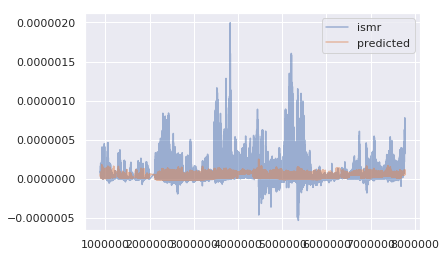

In [129]:
melt[['ismr','predicted']].plot(alpha=0.5)

In [130]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [131]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

NameError: name 'params' is not defined

In [59]:
for idx ,row in melt.iterrows():
    name = 

276.0
276.0
277.0
277.0
277.0
277.0
277.0
277.0
277.0
277.0
278.0
278.0
278.0
278.0
278.0
278.0
278.0
279.0
279.0
279.0
279.0
279.0
279.0
279.0
280.0
280.0
280.0
280.0
280.0
280.0
280.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.

301.0
301.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.

326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.

340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
342.0
342.0
342.0
342.

405.0
405.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.

496.0
496.0
496.0
496.0
496.0
496.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
503.0
503.

KeyboardInterrupt: 

In [49]:
melt.loc[(melt['eta'] == 276) & (melt['xi'] == 2024),'Tm_front_deep'] = 10

In [50]:
melt.head()

,ismr,eta,xi,Tm_front_deep
871424,7.383603e-08,276,2024,10.0
871425,6.678496e-08,276,2025,NaN
874570,6.874065e-08,277,2020,NaN
874571,5.488896e-08,277,2021,NaN
874572,4.619985e-08,277,2022,NaN
